In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize,word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
import spacy
import tensorflow
from keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Activation,GRU,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
nlp=spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings

<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/drugsComcombined_raw.csv')

In [ ]:
data.columns

Index(['Unnamed: 0', 'uniqueID', 'drugName', 'condition', 'review', 'rating',
       'date', 'usefulCount'],
      dtype='object')

In [ ]:
data.head()

Unnamed: 0  uniqueID                  drugName  \
0           0    206461                 Valsartan   
1           1     95260                Guanfacine   
2           2     92703                    Lybrel   
3           3    138000                Ortho Evra   
4           4     35696  Buprenorphine / naloxone   

                      condition  \
0  Left Ventricular Dysfunction   
1                          ADHD   
2                 Birth Control   
3                 Birth Control   
4             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8  03-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

## Droping some of the columns

In [ ]:
data.drop(['Unnamed: 0', 'uniqueID', 'drugName', 'condition','date', 'usefulCount'],axis=1,inplace=True)
data.review=data.review.astype(str)

In [ ]:
data.shape

(215063, 2)

### Categorizing the reviews as per ratings

In [ ]:
data['sentiment']=data.rating.map(lambda x:'negative' if x<=3 else ("neutral" if x>3 and x<=8 else 'positive'))

In [ ]:
data.head()

review  rating sentiment
0  "It has no side effect, I take it in combinati...       9  positive
1  "My son is halfway through his fourth week of ...       8   neutral
2  "I used to take another oral contraceptive, wh...       5   neutral
3  "This is my first time using any form of birth...       8   neutral
4  "Suboxone has completely turned my life around...       9  positive

<Axes: xlabel='sentiment', ylabel='count'>

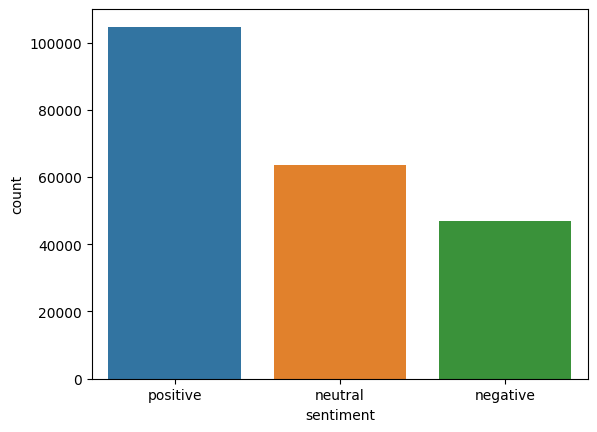

In [ ]:
sns.countplot(x=data.sentiment,data=data)

## Dropping some of the columns

In [ ]:
data.sentiment.value_counts()

positive    104713
neutral      63449
negative     46901
Name: sentiment, dtype: int64

### Labeling the sentiment column

In [ ]:
data.sentiment=data.sentiment.map({'negative':0,
                                   'neutral':1,
                                   'positive':2})

In [ ]:
data.head()

review  rating  sentiment
0  "It has no side effect, I take it in combinati...       9          2
1  "My son is halfway through his fourth week of ...       8          1
2  "I used to take another oral contraceptive, wh...       5          1
3  "This is my first time using any form of birth...       8          1
4  "Suboxone has completely turned my life around...       9          2

## Droping the rating column

In [ ]:
data.drop(['rating'],axis=1,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     215063 non-null  object
 1   sentiment  215063 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [ ]:
data.describe()

sentiment
count  215063.000000
mean        1.268814
std         0.795435
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000

## Value Count of each sentiment

In [ ]:
print(data.sentiment.value_counts())

2    104713
1     63449
0     46901
Name: sentiment, dtype: int64


In [ ]:
data.review=data.review.astype(str)

## Calculating the word frequencies

In [ ]:
def frequency_words(text):
  words_count=[]
  for word in text.split():
    words_count.extend(word)
  #Generating word frequences using value_counts in word-list
  word_freq=pd.Series(words_count).value_counts()
  word_freq[:100]#displaying top 100 words
  return word_freq

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
freq=frequency_words(data.review.str)

In [ ]:
freq

I             883057
and           563694
the           484954
to            425525
a             376651
               ...  
full).             1
Patch..but         1
bed..I             1
well.it            1
drinks).           1
Length: 211837, dtype: int64

## Generating the word Cloud Before data preprocessing

In [ ]:
from wordcloud import WordCloud

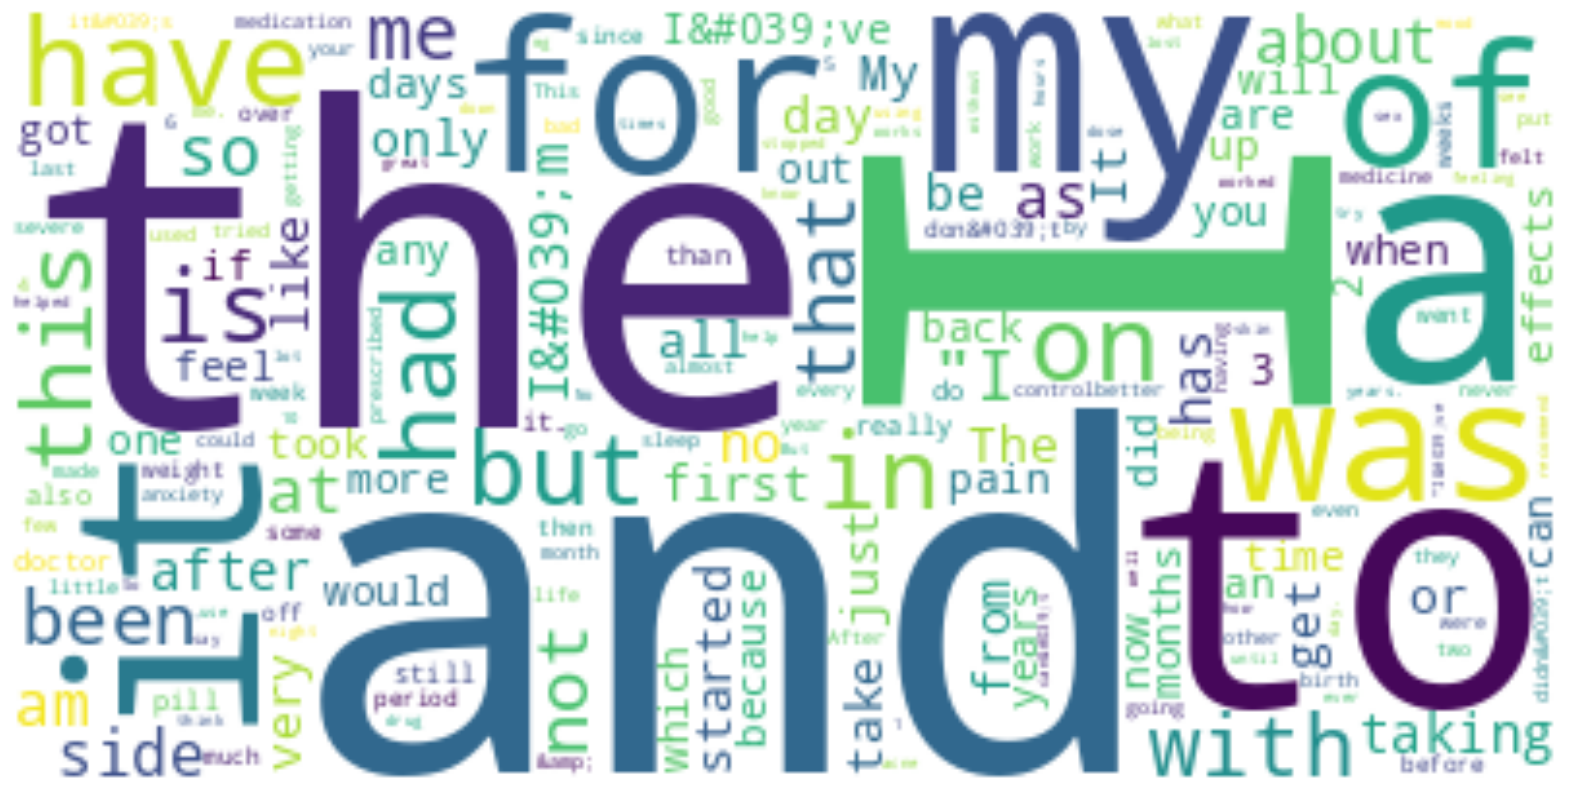

In [ ]:
plt.figure(figsize=(20,20))
wordc=WordCloud(max_words=200,width=400,height=200,background_color='white').generate_from_frequencies(freq)
plt.axis('off')
plt.imshow(wordc,interpolation='bilinear')
plt.show()

#### Word cloud for positive reviews

**interpolation='bilinear' is used to show smooth image

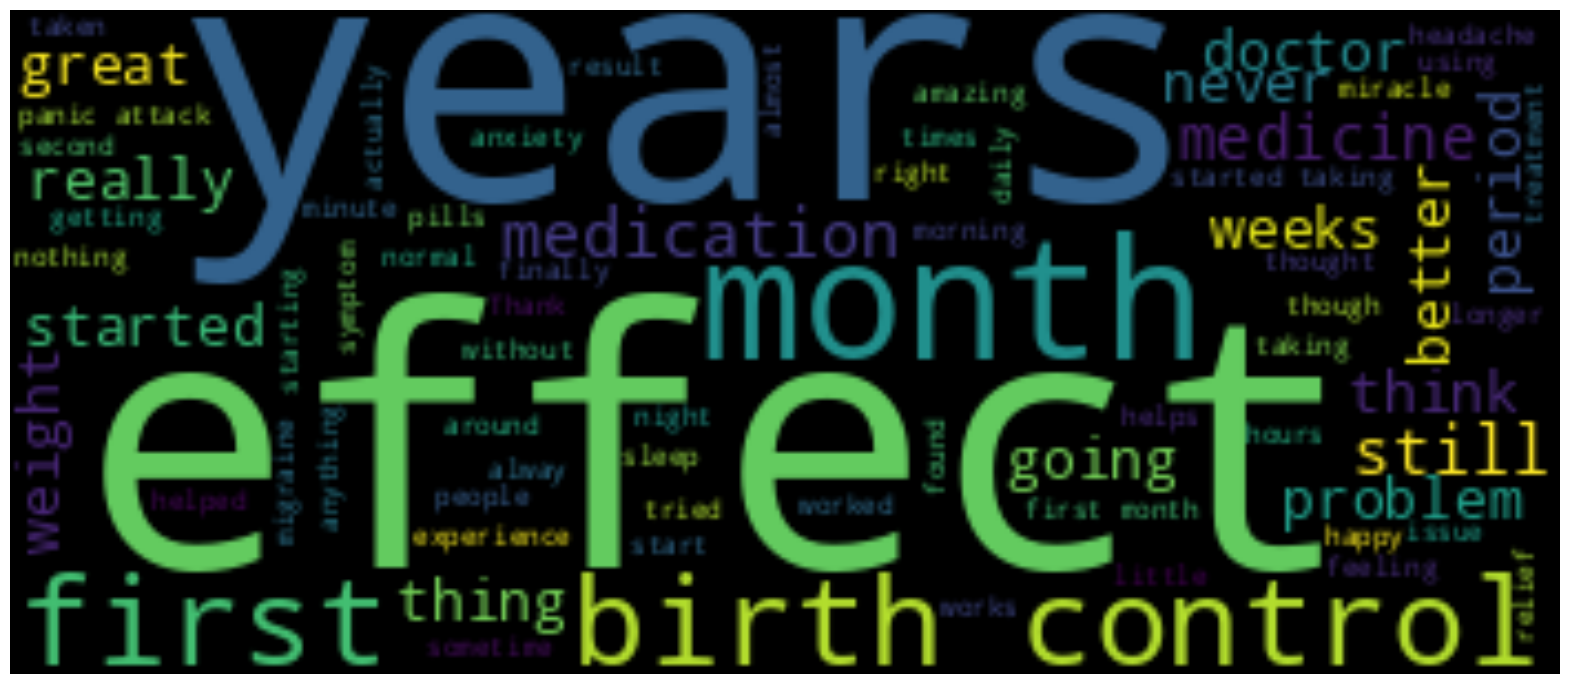

In [ ]:
plt.figure(figsize=(20,20))
Wc=WordCloud(max_words=500,width=350,height=150,min_word_length=5).generate(" ".join(data[data.sentiment==2].review))
plt.axis('off')
plt.imshow(Wc,interpolation='bilinear')
plt.show()

#### Word cloud for neutral reviews

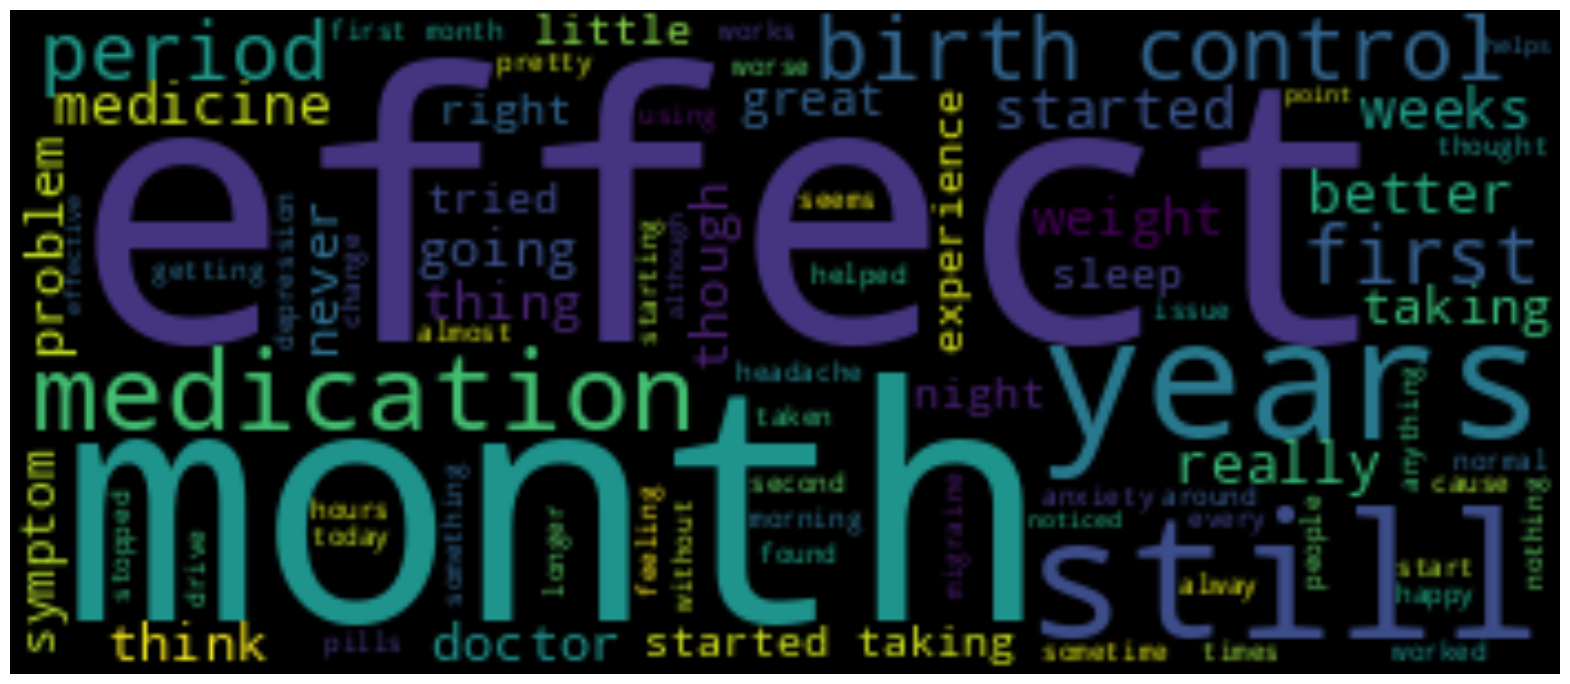

In [ ]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=350,height=150,min_word_length=5).generate(" ".join(data[data.sentiment==1].review))
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')
plt.show()

#### Word cloud for negative reviews

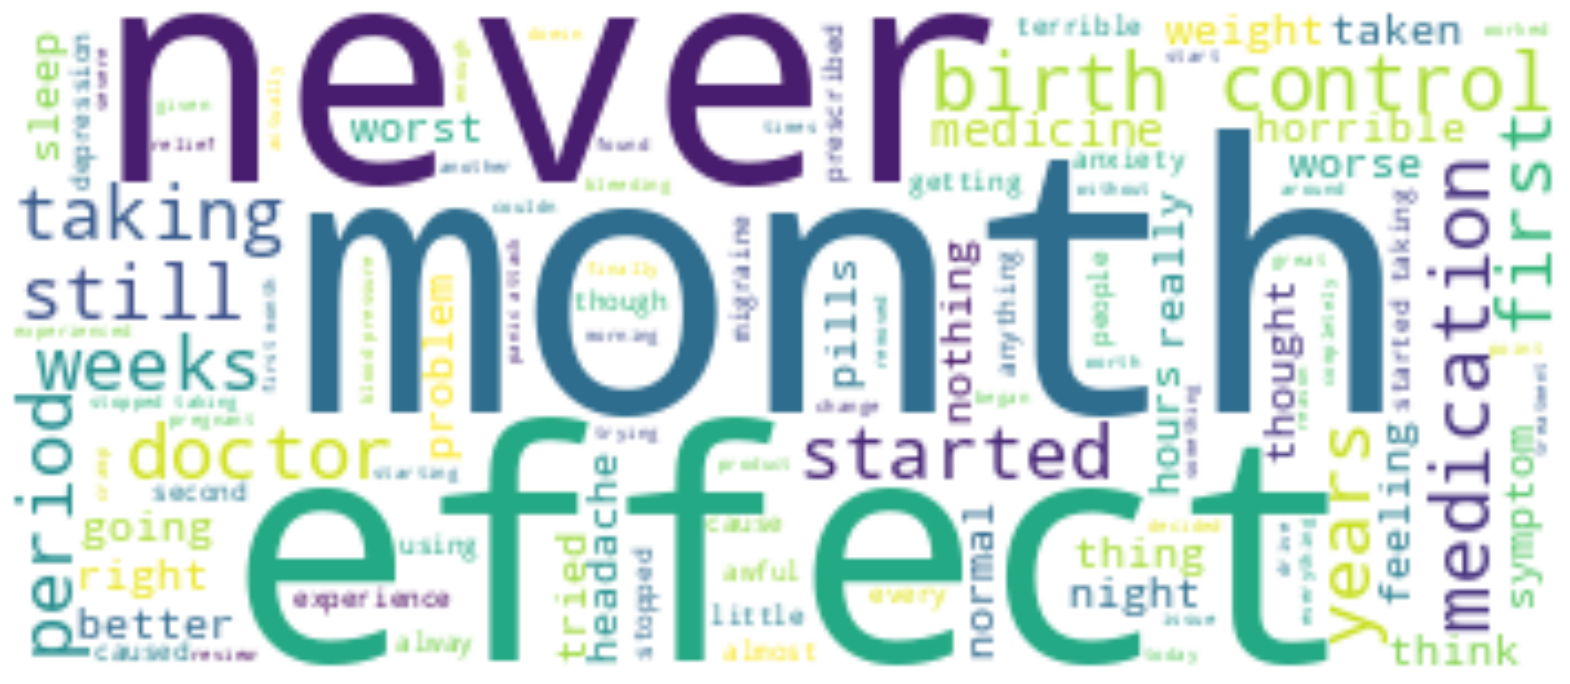

In [ ]:
plt.figure(figsize=(20,20))
WC=WordCloud(max_words=500,width=350,height=150,min_word_length=5,background_color='white').generate(" ".join(data[data.sentiment==0].review))
plt.axis('off')
plt.imshow(WC,interpolation='bilinear')
plt.show()

## Data Preprocessing

### Removing the html tags

In [ ]:
def cleaner_text(text):
  #removing the html tags
  text=re.sub(r"<.*?>"," ",text)
  return text


In [ ]:
data.review=data.review.apply(cleaner_text)

In [ ]:
data.review[5]

'"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches   severe lower bowel preassure like you need to go #2 but can&#039;t! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I&#039;m 50 &amp; work out 3Xs a week. Not worth side effects!"'

### Removing the punctuations associated with the text

In [ ]:
def remove_marks(text):
  text=re.sub(r"[!\"#$%&\\'()*+,-\.\/:;<=>\?\]\^_\`{\|}\]\0-9]+"," ",text)
  return text

In [ ]:
data.review=data.review.apply(remove_marks)

In [ ]:
data.review[5]

' nd day on mg started to work with rock hard erections however experianced headache lower bowel preassure rd day erections would wake me up amp hurt Leg ankles aches severe lower bowel preassure like you need to go but can t Enjoyed the initial rockhard erections but not at these side effects or for months supply I m amp work out Xs a week Not worth side effects '

### removing apstrohs and backquotes


In [ ]:
def remove_ab(text):
  text=re.sub("(\'s)|([`'])+"," ",text)
  return text

In [ ]:
data.review=data.review.apply(remove_ab)

### Chat word treatment

In [ ]:
dd={
    "D":'had',
    "S":'is',
    "LL":'will',
    "VE":'have',
    "M":'am',
    "U":'you',
    "T":'not',
    "COULDN":'could',
    "SHOULDN":'should',
    "WOULDN":'would',
    "DIDN":'did',
    "DON":'do',
    "DOESN":'does',
    "AREN":'are',
    "WASN":'was',
    "AIN":'is',
    "ISN":'is',
    'TKTS':'tickets',
    'USF':'useful',
    'C':'see',
    'U':'you',
    "M":'am',
    "VE":'have',
    "LL":'will',
    "T":'not',
    "RE":'are',
    '1':'one',
    '2':'two',
    '3':'three',
    '4':'four',
    '5':'five',
    '6':'six',
    '7':'seven',
    '8':'eight',
    '9':'nine',
    '10':'ten',
    'ND':'second',
     "MG":'milligram',
     "XS":"times",
    "X":"times",

}

In [ ]:
def chat_word(text):
    new_text=[]
    for word in text.split():
            if word.upper() in dd.keys():
                new_text.append(dd[word.upper()])
            else:
                new_text.append(word)
    return " ".join(new_text)


In [ ]:
data.review=data.review.apply(chat_word)

### More preprocessin

In [ ]:
data.review=data.review.astype(str)

In [ ]:
data.review=data.review.astype(str)
d={
    "AMP":'adenosine monophosphate',
    "ETC":'and others',
    'RX':'times',
    "BC":'birth control',
    "LBS":'launois bensaude syndrome',
    'DIARRHEA':'diarrhoea',
    'UTI':'urinary tract infection',
    'DR':'data rate',
    'MED':'meditation',
    'NOPE':'no',
    'CD':'cluster of differentiation',
    'LOL':'laughing out loud',
    'PCP':'primary care provider',
    'MGS':'meckel gruber syndrome',
    'HRS':'hours',
    'RD':'rare disease',
    'ER':'emergency room',
    'IBS':'irritable bowel syndrome',
    'GP':'general practitioner',
    '@':'',
    'VL':'viral load',
    'NREVOUS':'nervous',
    's':'is',
    'HEP':'hepatitis',
    'UK':'united kingdom',
    'IUD':'intrauterine device',
    'CKD':'chronic kidney disease',
    'MCG':'microgram',
    'NOV':'november',
    'DR':'doctor',
    'DEPO':'depo-provera',
    'DOC':'doctor',
    'XR':'extended release',
    'RD':'round',
    'ST':'start',
    'YAY':'happiness',
    'RSQUO':" ",
    'YRS':'years',
    'OMG':'oh my god',
    'th':'sixth',
}
def chat_treatment(text):
    new_text=[]
    for word in text.split():
        if word.upper() in d.keys():
            new_text.append(d[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)
data.review=data.review.apply(chat_treatment)

In [ ]:
data.review[5]

'second day on milligram started to work with rock hard erections however experianced headache lower bowel preassure round day erections would wake me up adenosine monophosphate hurt Leg ankles aches severe lower bowel preassure like you need to go but can not Enjoyed the initial rockhard erections but not at these side effects or for months supply I am adenosine monophosphate work out times a week Not worth side effects'

### Removing the stopwords

In [ ]:
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stops=stopwords.words('english')

In [ ]:
def remove_stops(text):
  new_text=[]
  #converting the text into the lower-case
  text=text.lower()
  tokens=word_tokenize(text)
  for word in tokens:
    if word not in stops:
      new_text.append(word)
  return " ".join(new_text)


In [ ]:
data.review=data.review.apply(remove_stops)

In [ ]:
data.review[5]

'second day milligram started work rock hard erections however experianced headache lower bowel preassure round day erections would wake adenosine monophosphate hurt leg ankles aches severe lower bowel preassure like need go enjoyed initial rockhard erections side effects months supply adenosine monophosphate work times week worth side effects'

### Performing Lemmatization using Spacy

In [ ]:
nlp=spacy.load('en_core_web_sm')

In [ ]:
def lemmatization(text):
  new_text=[]
  doc=nlp(text)
  for token in doc:
    new_text.append(token.lemma_)
  return " ".join(new_text)

In [ ]:
data.review=data.review.apply(lemmatization)

### Saving the cleaned dataset

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/complete_preporcessing_drug_review.csv')

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/complete_preporcessing_drug_review.csv')

In [ ]:
data.review=data.review.astype(str)


In [ ]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

## Generating the word clouds after Performing data-preprocessing


### For positive reviews

In [ ]:
from wordcloud import WordCloud

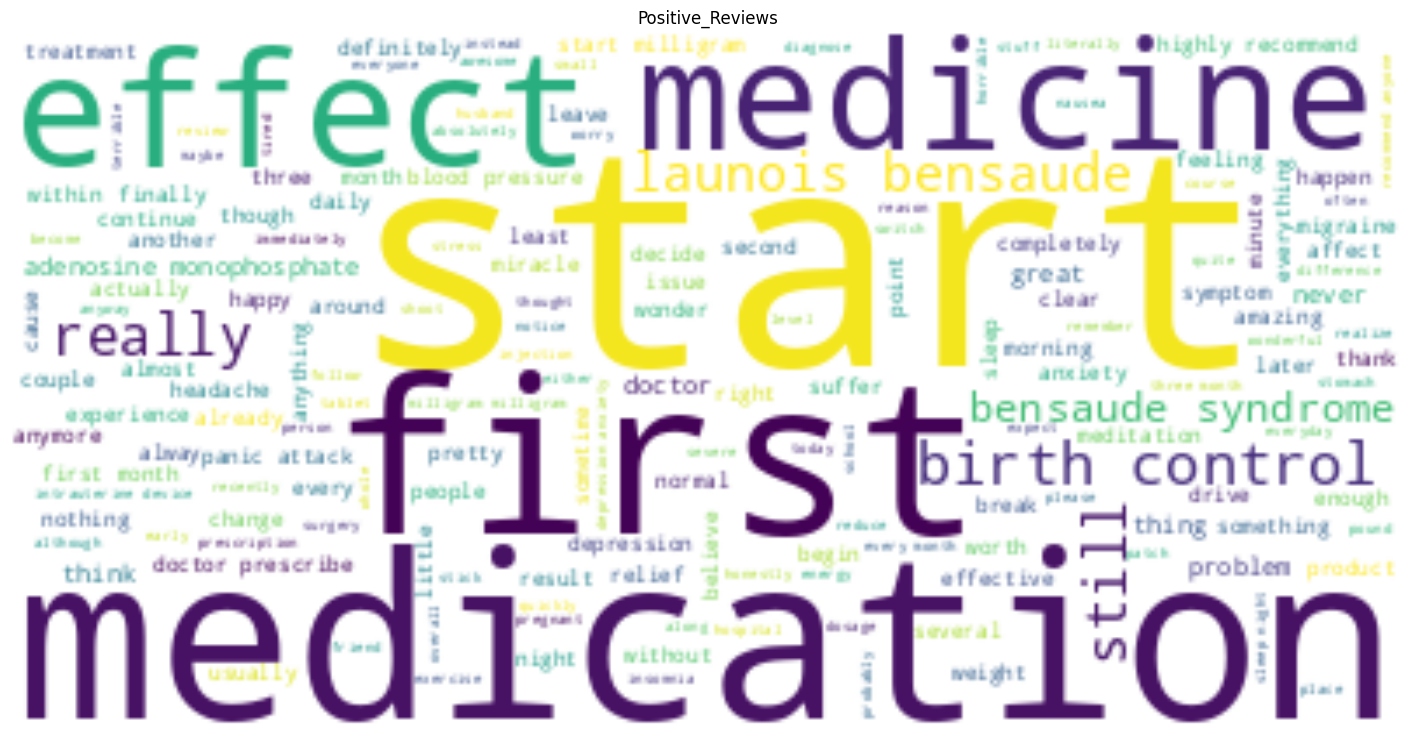

In [ ]:
plt.figure(figsize=(18,18))
WordC=WordCloud(max_words=500,width=400,height=200,min_word_length=5,background_color='white').generate(" ".join(data[data.sentiment==2].review))
plt.title('Positive_Reviews')
plt.axis('off')
plt.imshow(WordC,interpolation='bilinear')
plt.show()


###  For Neutral reviews

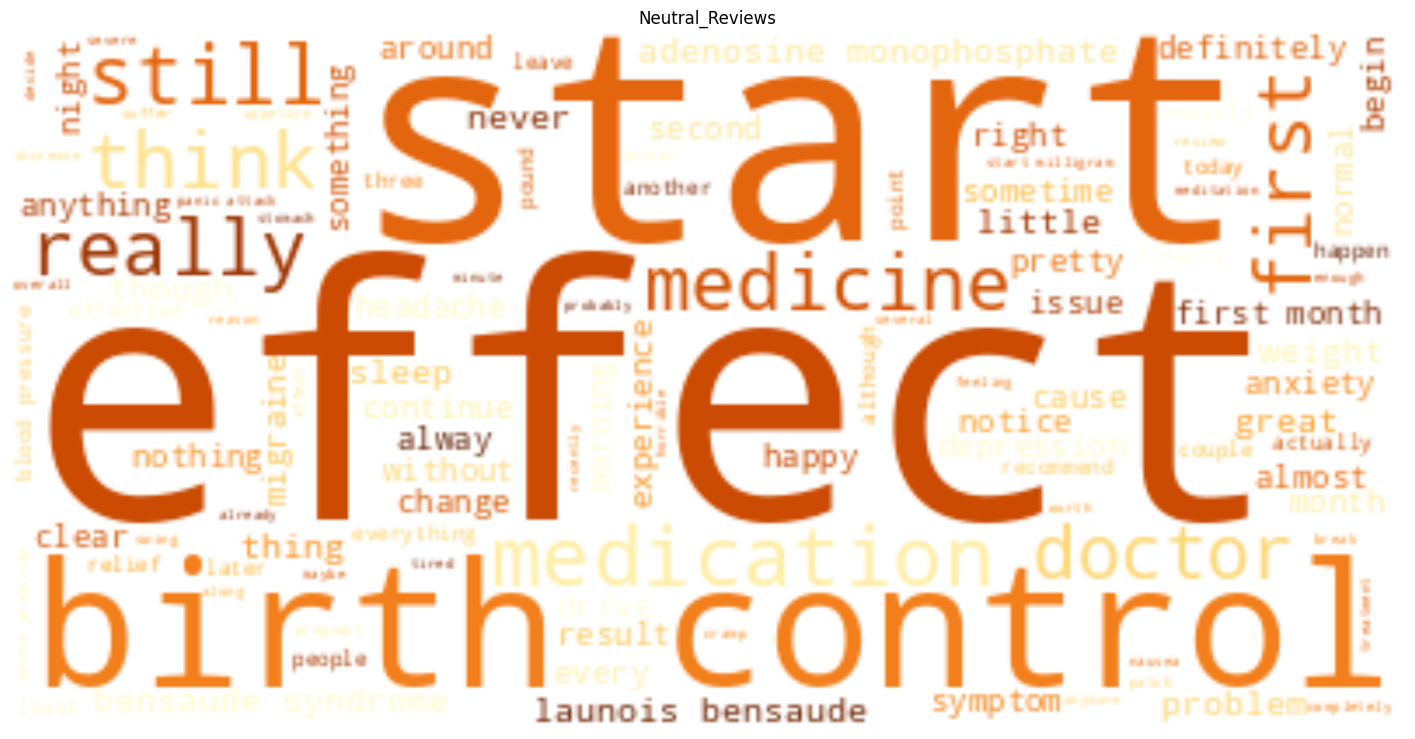

In [ ]:
plt.figure(figsize=(18,18))
Wcloud=WordCloud(max_words=500,width=400,height=200,min_word_length=5,colormap="YlOrBr",background_color='white').generate(" ".join(data[data.sentiment==1].review))
plt.title('Neutral_Reviews')
plt.axis('off')
plt.imshow(Wcloud,interpolation='bilinear')
plt.show()


###  For Negative reviews

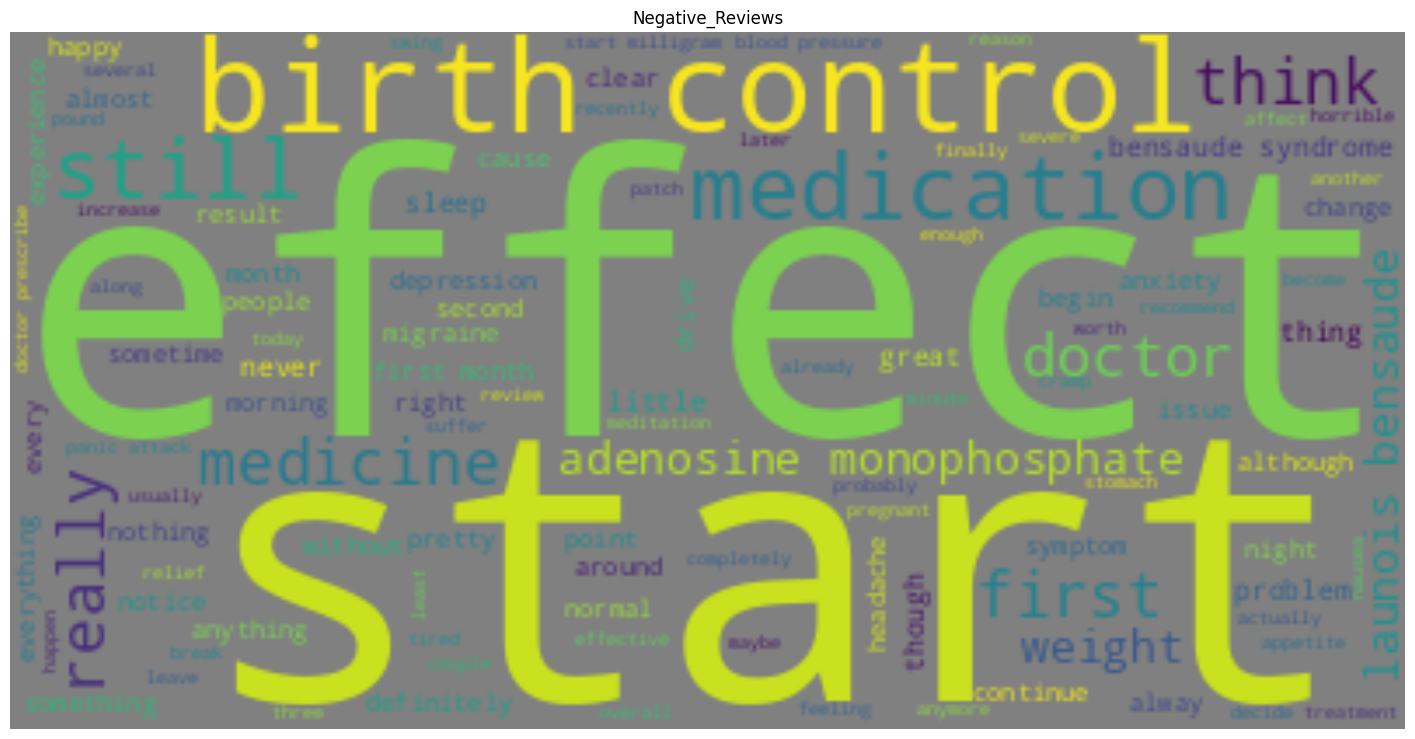

In [ ]:
plt.figure(figsize=(18,18))
Wcloud=WordCloud(max_words=500,width=400,height=200,min_word_length=5,background_color='grey').generate(" ".join(data[data.sentiment==1].review))
plt.title('Negative_Reviews')
plt.axis('off')
plt.imshow(Wcloud,interpolation='bilinear')
plt.show()


In [ ]:
data.review

0         side effect take combination bystolic milligra...
1         son halfway fourth week intuniv become concern...
2         use take another oral contraceptive pill cycle...
3         first time use form birth control glad go patc...
4         suboxone completely turn life around feel heal...
                                ...                        
215058    take tamoxifen year side effect severe sweatin...
215059    take lexapro escitaploprgram since february fi...
215060    married year old kid take pill hassle decide g...
215061    prescribe nucynta severe neck shoulder pain ta...
215062                                                 work
Name: review, Length: 215063, dtype: object

In [ ]:
data.review=data.review.astype(str)

<Axes: xlabel='sentiment', ylabel='count'>

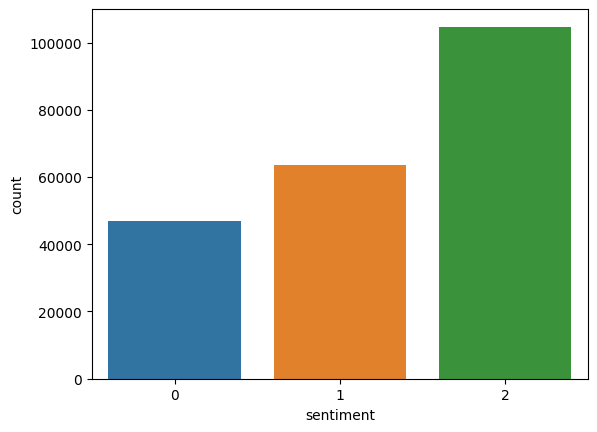

In [ ]:
sns.countplot(x=data.sentiment,data=data)